# ACN Call Option

Install the yfinance package, which is the downloader connected with the Yahoo Fiannce API.

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U matplotlib

Requirement already up-to-date: matplotlib in /opt/anaconda3/lib/python3.8/site-packages (3.3.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

Download the data and save it as a pandas DataFrame.

In [210]:
initial_data = yf.download("ACN", start="2020-01-07", end="2020-10-07")

[*********************100%***********************]  1 of 1 completed


In [211]:
initial_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-07,203.199997,206.259995,203.190002,203.929993,200.707962,3097400
2020-01-08,204.000000,205.449997,203.529999,204.330002,201.101685,2271300
2020-01-09,205.500000,207.279999,205.160004,206.149994,202.892914,2910600
2020-01-10,206.929993,208.309998,206.729996,207.660004,204.379059,1573100
2020-01-13,207.490005,209.839996,207.490005,209.589996,206.278564,2202800


#### Show the movement of ACN for the period 07 Jan 2020 to 07 Oct 2020.

In [213]:
initial_data['Adj Close'].head()

Date
2020-01-07    200.707962
2020-01-08    201.101685
2020-01-09    202.892914
2020-01-10    204.379059
2020-01-13    206.278564
Name: Adj Close, dtype: float64

In [214]:
data.head()

Date
2019-12-09    198.838013
2019-12-10    198.690384
2019-12-11    199.103760
2019-12-12    200.698151
2019-12-13    203.394852
Name: Adj Close, dtype: float64

In [91]:
data.tail()

Date
2020-11-30    249.089996
2020-12-01    252.270004
2020-12-02    249.660004
2020-12-03    249.929993
2020-12-04    253.440002
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

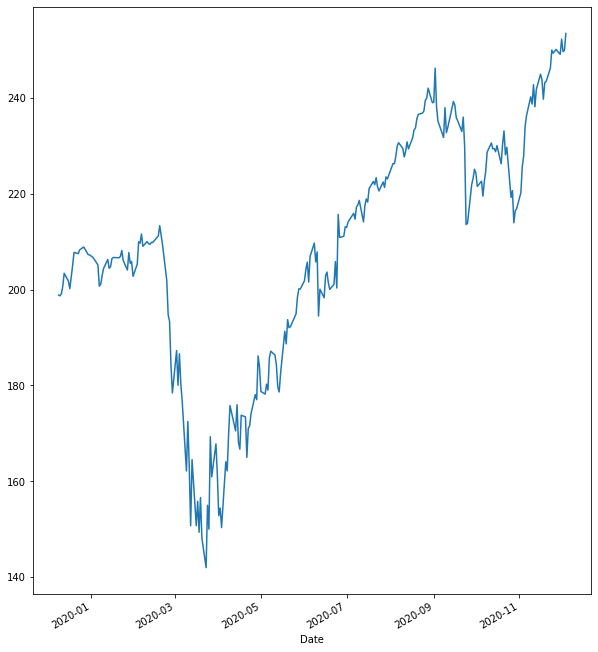

In [92]:
data.plot(figsize=(10, 12), subplots=True)

#### Calculate the historical volatility of ANC

In [11]:
ACN = yf.download("ACN", start="2019-12-07", end="2020-12-07")

[*********************100%***********************]  1 of 1 completed


In [12]:
S = ACN['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 253.44 .


In [13]:
log_return = np.log(ACN['Adj Close'] / ACN['Adj Close'].shift(1))
vol_h = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 41.11 %


# The Methodology of calculting option value.

#### 1.Binomial Tree (CRR Tree)

In [62]:
import numpy as np
import os

In [63]:
S0 = 253.4              # spot stock price
K = 250.0               # strike price
T = 1.0                 # maturity 
r = 0.1                 # risk free rate 
sig = 0.4               # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "call"         # payoff

Step 1: Create the binomial price tree

In [64]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

Create a loop below to calculate price of next node.

In [65]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [66]:
S

array([[253.4       , 319.22921132, 402.15978438, 506.63437567],
       [  0.        , 201.14562741, 253.4       , 319.22921132],
       [  0.        ,   0.        , 159.66678543, 201.14562741],
       [  0.        ,   0.        ,   0.        , 126.74141962]])

In [67]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.5152570097939254

Step 2: Find option value at each final node

In [68]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[  0.        ,   0.        ,   0.        , 256.63437567],
       [  0.        ,   0.        ,   0.        ,  69.22921132],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

Step 3: Find option value at earlier nodes

In [69]:
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 55.9502944 ,  96.09170511, 160.35575926, 256.63437567],
       [  0.        ,  17.19428956,  34.5014073 ,  69.22921132],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

In [70]:
print('European ' + payoff, str( V[0,0]))

European call 55.95029439840941


#### 2.Monte Carlo Simulation

In [71]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [72]:
T = 1
r = 0.1
sigma = 0.41
S0 = 253.4
K = 250.0

In [73]:
S = mcs_simulation_np(1000)

In [74]:
S = np.transpose(S)
S

array([[253.4       , 254.28734541, 255.70706193, ..., 255.71816938,
        254.94823689, 250.85343172],
       [253.4       , 251.44666857, 249.52902274, ..., 355.87878543,
        356.89346627, 359.09403242],
       [253.4       , 253.10580407, 253.38566487, ..., 154.14567706,
        157.9205368 , 155.39425393],
       ...,
       [253.4       , 256.57188961, 258.33927348, ..., 524.08304298,
        520.80856594, 515.61386425],
       [253.4       , 250.66207414, 249.07910181, ..., 232.78737529,
        237.9370402 , 234.14774047],
       [253.4       , 248.44048302, 250.86475391, ..., 328.21741554,
        327.09106287, 329.69130642]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

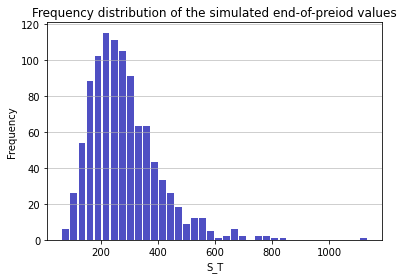

In [75]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [76]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))2:0

European call 59.03476190202256


#### Black-Scholes Model

In [107]:
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf

Non-Dividend Paying Options

In [208]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    
    return option_value

In [209]:
euro_option_bs(253.4, 250.0, 1, 0.1, 0.4, 'call')

53.10720339307325

# Greeks

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

In [103]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to expiry
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [104]:
euro_option_bsm(254.4, 250, 1, 0.1, 0, 0.41, 'call')

54.69366532351789

In [105]:
S = np.linspace(50,150,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 250, 1, 0.1, 0, 0.41, 'call')

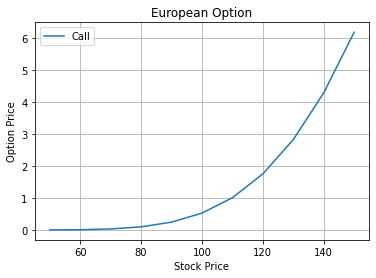

In [106]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Call'])

#### Delta

In [99]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [142]:
delta(254.4, 250, 1, 0.1, 0, 0.41, 'call')

0.6884479774818354

In [143]:
S = np.linspace(50,250,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 250, 1, 0.1, 0, 0.41, 'call')

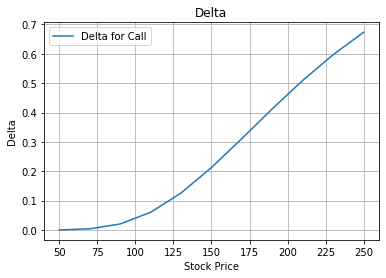

In [146]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call'])

Gamma

In [179]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [180]:
gamma(254.4, 250, 1, 0.1, 0, 0.41, 'call')

0.003389703956934967

In [181]:
S = np.linspace(50,250,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 250, 1, 0.1, 0, 0.41, 'call')

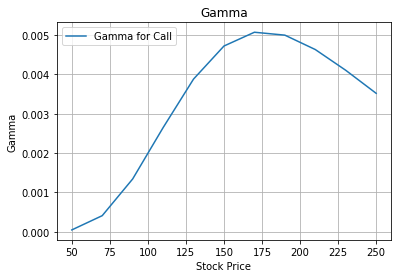

In [182]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call'])

Speed

In [183]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [184]:
speed(254.4, 250, 1, 0.1, 0, 0.41, 'call')

2.9295794855597597e-05

In [185]:
S = np.linspace(50,250,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 250, 1, 0.1, 0, 0.41, 'call')

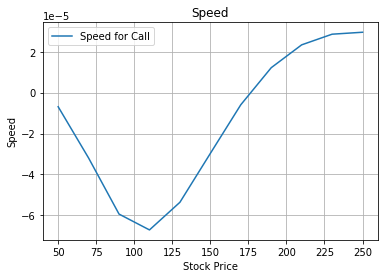

In [186]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call'])

Theta

In [194]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) + q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)

    return theta

In [195]:
theta(254.4, 250, 1, 0.1, 0, 0.41, 'call')

6.394094496061095

In [196]:
(1/12-1/52)*theta(254.4, 250, 1, 0.1, 0, 0.41, 'call')

0.4098778523116086

In [197]:
T = np.linspace(0.25,3,12)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(254.4,250, T[i], 0.1, 0, 0.41, 'call')
    

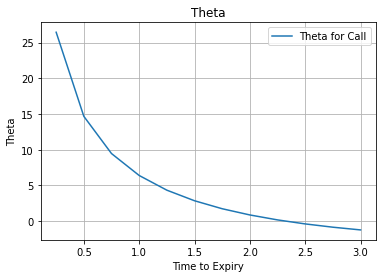

In [198]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call'])

 Rho

In [199]:
def rho(S, K, T, r, q, vol, payoff):
    
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)

    return rho

In [200]:
rho(254.4, 250, 1, 0.1, 0, 0.41, 'call')

120.44750014786105

In [201]:
0.01*rho(254.4, 250, 1, 0.1, 0, 0.41, 'call')

1.2044750014786105

In [202]:
r = np.linspace(0,0.1,11)
Rho_Call = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(254.4, 250, 1, r[i], 0, 0.41, 'call')

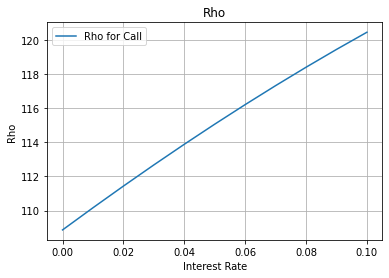

In [203]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call'])

Vega

In [166]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [167]:
vega(254.4, 250, 1, 0.1, 0, 0.41, 'call')

89.94558297974244

In [205]:
vol = np.linspace(0.41,0.8,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(254.4, 250, 1, 0.1,0.41, vol[i], 'call')

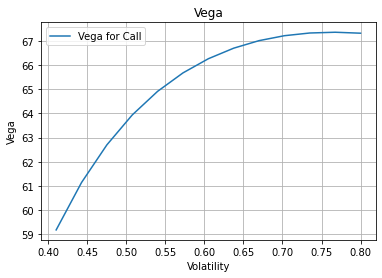

In [206]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call'])

In [207]:
0.01*vega(254.4, 250, 1, 0.1, 0, 0.41, 'call')

0.8994558297974244